In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

#For editable text. Except latex text is still shapes sadly
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
sns.set_style("whitegrid")
font = {'size' : 20}
lines = {'linewidth' : 0.5}
fig = {'figsize' : (2.5, 1.5)}
mpl.rc('font', **font)
mpl.rc('lines', **lines)
mpl.rc('figure', **fig)

from scipy.stats import mannwhitneyu


from matplotlib.colors import ListedColormap
from nheatmap import nhm, scripts

import itertools # for making comparisons
from scipy.stats import zscore # for heatmaps

# for MH correction
import statsmodels.stats.multitest as smt

from sklearn.preprocessing import StandardScaler


# for annotating volcano plots
from adjustText import adjust_text
import adjustText as at

/Users/sevahn/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def save_figure_pdf(fig, path_to_save):
	'''
	Utility fxn to save a figure without having to retype all the required options.
	Input:
		fig - a matplotlib.pyplot.figure instance with the figure you'd like to save
		path_to_save - the path you'd like to save the figure to
	Returns: Nothing but there should now be a pdf version in 300 dpi with a transparent bkg at path_to_save
	'''
	fig.savefig(path_to_save, dpi = 300, bbox_inches = 'tight', transparent = True)

In [3]:
color_pal = {}

color_pal['urinary_plasma_sediment'] = '#F47E53'
color_pal['urinary_plasma_supt'] = "#FFCE44"

color_pal['hematopoietic_plasma_sediment'] = '#EF233C'
color_pal['hematopoietic_plasma_supt'] = '#FF8FA3'

color_pal['rest_plasma_sediment'] = '#003049'
color_pal['rest_plasma_supt'] = '#669bbc'

color_pal['urinary'] = "#FFCE44"
color_pal['hematopoietic'] = '#EF233C'
color_pal['rest'] = '#669bbc'

color_pal['not_sig'] = '#ced4da'

In [4]:
plasma_fracs = pd.read_csv('../data/deconvolution_fractions/bioivt_nci_fracs_fractions__20230518.csv',
                          sep = ",", index_col = 0).T

plasma_fracs.index = [i.split("-")[0] for i in plasma_fracs.index]


In [5]:
# redid the creatinine because the normals that weren't N1/N2 were not going through
urine_fracs = pd.read_csv("../data/deconvolution_fractions/pee_repool_final_fractions__20230517.csv",
                         sep = ",", index_col = 0).T

urine_fracs.index = [i.split('-NUSVR')[0] for i in urine_fracs.index]

In [6]:
[i for i in urine_fracs.index if 'repool' not in i]

['1742_sediment',
 '1749_supt_purple',
 '1761_sediment',
 'N1_sediment',
 'N2_sediment',
 '1749_sediment']

In [7]:
all_fracs = pd.concat([plasma_fracs, urine_fracs], axis = 0)

In [8]:
all_fracs['biofluid'] = ['sediment' if 'sediment' in i else 'supt' if 'supt' in i else 'plasma' for i in all_fracs.index]
all_fracs['is_stone'] = ['normal' if i[0] == 'N' or i[0:3] == 'SRR' else 'stone' for i in all_fracs.index ]

**compare volcanos**

In [9]:
adataMeta = pd.read_csv("../data/deconvolution_fractions/cleanTSP_obsDF.csv",
                        sep = ",", index_col = 0)

sigMat = pd.read_csv("../data/deconvolution_fractions/tsp_v1_basisMatrix.txt",
                    sep = "\t", index_col = 0)

/var/folders/4z/m0lhwcb91fxf79_3lnvvyjbm0000gn/T/ipykernel_75182/3941848353.py:1: DtypeWarning: Columns (1,2,4,8,9,11,13,14,15,25,26,27,29,30,31,32,33,34,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  adataMeta = pd.read_csv("../data/deconvolution_fractions/cleanTSP_obsDF.csv",


In [10]:
df = all_fracs #.iloc[:, :-2] # ignore r and rmse

df['sample'] = df.index
df['biofluid'] = ['sediment' if 'sediment' in i else 'supt' if 'supt' in i else 'plasma' for i in df.index]

In [11]:
cellToCompartment = {}
for cell in np.unique(adataMeta["cell_ontology_class"].tolist()):
    comp = np.unique(adataMeta[adataMeta["cell_ontology_class"] == cell]["compartment"]).tolist()[0]
    cellToCompartment[cell] = comp
    
    
# get the labels that need to be added
missingKeys = np.setdiff1d(sigMat.columns, list(cellToCompartment.keys()))

for k in missingKeys:
    cellInKey = k.split("/")
    consensus = []
    for c in cellInKey:
        consensus += [cellToCompartment[c]]
        
    compThisKey = np.unique(consensus).tolist()
    if len(compThisKey) == 1: # eg they're all the same compartment
        cellToCompartment[k] = compThisKey[0]
    else:
        print(k)
        print(compThisKey)
        
cellToCompartment["club cell of prostate epithelium/hillock cell of prostate epithelium/hillock-club cell of prostate epithelium"] = "epithelial"
cellToCompartment["fibroblast/mesenchymal stem cell"] = "stromal"

club cell of prostate epithelium/hillock cell of prostate epithelium/hillock-club cell of prostate epithelium
['epithelial', 'nan']
fibroblast/mesenchymal stem cell
['immune', 'stromal']


In [12]:
compartmentToCell = {}
for i in cellToCompartment:
    
    comp = cellToCompartment[i]
    if comp in compartmentToCell:
        compartmentToCell[comp] += [i]
    else:
        compartmentToCell[comp] = [i]

In [13]:
hematopoietic = compartmentToCell['immune']

urinary = ['schwann cell',
         'basal cell of prostate epithelium',
         'bladder urothelial cell',
         'club cell of prostate epithelium/hillock cell of prostate epithelium/hillock-club cell of prostate epithelium',
         'kidney epithelial cell',
         'luminal cell of prostate epithelium']

In [14]:
df = df.loc[[i for i in df.index if 'SRR' in i or i[0] == 'N']]

In [15]:
# drop ["r", "rmse", "biofluid", "is_stone", "sample"]
deconv_fracs = df.iloc[:, :-5] 

In [16]:
frac_thresh = 0.001
deconv_fracs[deconv_fracs < frac_thresh] = 0

/var/folders/4z/m0lhwcb91fxf79_3lnvvyjbm0000gn/T/ipykernel_75182/1313862822.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deconv_fracs[deconv_fracs < frac_thresh] = 0
/var/folders/4z/m0lhwcb91fxf79_3lnvvyjbm0000gn/T/ipykernel_75182/1313862822.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deconv_fracs[deconv_fracs < frac_thresh] = 0


In [17]:
plasma_id = [i for i in deconv_fracs.index if 'SRR' in i]
sed_id = [i for i in deconv_fracs.index if 'sediment' in i and i[0] == 'N']
sed_id = [i for i in sed_id if 'N4' not in i]
supt_id = [i for i in deconv_fracs.index if 'supt' in i and i[0] == 'N']

plasma_supt_comp = []
plasma_supt_pval = []
plasma_supt_lfc = []

plasma_sed_comp = []
plasma_sed_pval = []
plasma_sed_lfc = []


median_supt_plasma_size = []
median_sed_plasma_size = []

log_offset = 0.001 

for ct in deconv_fracs.columns: # last two are 'sample' and 'biofluid'
    
    plasma = deconv_fracs.loc[plasma_id, ct].values
    sed = deconv_fracs.loc[sed_id, ct].values
    supt = deconv_fracs.loc[supt_id, ct].values
    
    # do the plasma vs supt comparison
    plasma_supt = np.concatenate([plasma, supt])
    minority_plasmaSupt = min([len(plasma), len(supt)]) / np.sum([len(plasma), len(supt)])
    propNonzero_plasmaSupt = np.count_nonzero(plasma_supt) / len(plasma_supt)
    
    
    
    if propNonzero_plasmaSupt >= minority_plasmaSupt:
        u_plasmaSupt, p_plasmaSupt = mannwhitneyu(plasma, supt)
        
        plasma_supt_comp += [ct + "_plasma_supt"]
        plasma_supt_pval += [p_plasmaSupt]
 
        lfc = np.median(np.log2(supt + log_offset)) - np.median(np.log2(plasma + log_offset))
        plasma_supt_lfc += [np.median(np.log2(supt + log_offset)) - np.median(np.log2(plasma + log_offset))]
        
        if lfc > 0:
            median_supt_plasma_size += [np.median(supt)]
        else: median_supt_plasma_size += [np.median(plasma)]
            
        
    # perform plasma vs sediment comparison
    plasma_sed = np.concatenate([plasma, sed])
    
    minority_plasmaSed = min([len(plasma), len(sed)]) / np.sum([len(plasma), len(sed)])
    propNonzero_plasmaSed = np.count_nonzero(plasma_sed) / len(plasma_sed)
        
    
    if propNonzero_plasmaSed >= minority_plasmaSed:
        u_plasmaSed, p_plasmaSed = mannwhitneyu(plasma, sed)
        
        
        plasma_sed_pval += [p_plasmaSed]
        plasma_sed_comp += [f"{ct}_plasma_sed"]
        
        lfc = np.median(np.log2(sed + log_offset)) - np.median(np.log2(plasma + log_offset))
        
        plasma_sed_lfc += [np.median(np.log2(sed + log_offset)) - np.median(np.log2(plasma + log_offset))]
        
        if lfc > 0:
            median_sed_plasma_size += [np.median(sed)]
        else:
            median_sed_plasma_size += [np.median(plasma)]
    

In [18]:
res_supt = pd.DataFrame(data = [plasma_supt_pval, plasma_supt_lfc],
                  index = ['p_val', 'lfc']).T
res_supt['median_fraction'] = median_supt_plasma_size
res_supt['comparison'] = 'plasma_supt'
res_supt.index = plasma_supt_comp

In [19]:
res_sed = pd.DataFrame(data = [plasma_sed_pval, plasma_sed_lfc],
                  index = ['p_val', 'lfc']).T
res_sed.index = plasma_sed_comp
res_sed['median_fraction'] = median_sed_plasma_size
res_sed['comparison'] = 'plasma_sediment'

In [20]:
res = pd.concat([res_sed, res_supt],
         axis = 0)

In [21]:
a, adj_p, c, d = smt.multipletests(res['p_val'],
                 alpha = 0.1, method = 'fdr_bh')
res['adj_p_val'] = adj_p
res['-log10(p)'] = -np.log10(res['adj_p_val'])
res['-log10(p_noadj)'] = -np.log10(res['p_val'])

In [22]:
res.index = [i.split("_")[0] for i in res.index]

In [23]:
p_thresh = 0.05
sig_hits = res[res["adj_p_val"] <= p_thresh]
sig_hits.index.name = "celltype"

In [24]:
sig_hits.reset_index(inplace = True)

In [25]:
ct_urine_up = sig_hits[sig_hits.lfc > 0].sort_values(by = 'adj_p_val')

In [26]:
# cell types in both urine cfRNA and cellular urine RNA
ct, count = np.unique(ct_urine_up.celltype, return_counts = True)

In [27]:
res['category'] = ['urinary' if i in urinary else 'hematopoietic' if i in hematopoietic else 'rest' for i in res.index]

In [28]:
labelConversion = {}


labelConversion["gland cell"] = "acinar cell of salivary gland/myoepithelial cell"
labelConversion["respiratory ciliated cell"] = "ciliated cell/lung ciliated cell"
labelConversion["prostate epithelia"] = "club cell of prostate epithelium/hillock cell of prostate epithelium/hillock-club cell of prostate epithelium"
labelConversion["salivary/bronchial secretory cell"] = "duct epithelial cell/serous cell of epithelium of bronchus"
labelConversion["intestinal enterocyte"] = "enterocyte of epithelium of large intestine/enterocyte of epithelium of small intestine/intestinal crypt stem cell of large intestine/large intestine goblet cell/mature enterocyte/paneth cell of epithelium of large intestine/small intestine goblet cell"
labelConversion["erythrocyte/erythroid progenitor"] = "erythrocyte/erythroid progenitor"
labelConversion["fibroblast/mesenchymal stem cell"] = "fibroblast/mesenchymal stem cell"
labelConversion["intestinal secretory cell"] = "intestinal enteroendocrine cell/paneth cell of epithelium of small intestine/transit amplifying cell of small intestine"
labelConversion["ionocyte/luminal epithelial cell of mammary gland"] = "ionocyte/luminal epithelial cell of mammary gland"
labelConversion["secretory cell"] = "mucus secreting cell/secretory cell/tracheal goblet cell"
labelConversion["pancreatic alpha/beta cell"] = "pancreatic alpha cell/pancreatic beta cell"
labelConversion["respiratory secretory cell"] = "respiratory goblet cell/respiratory mucous cell/serous cell of epithelium of trachea"
labelConversion["basal prostate cell"] = "basal cell of prostate epithelia"
labelConversion["intestinal crypt stem cell"] = "immature enterocyte/intestinal crypt stem cell/intestinal crypt stem cell of small intestine/transit amplifying cell of large intestine"
    
revLabs = {}
for l in labelConversion:
    revLabs[labelConversion[l]] = l

In [29]:
cg_celltypes = []
for i in res.index:
    if i in revLabs.keys():
        cg_celltypes += [revLabs[i]]
    else: cg_celltypes += [i]
        
# capitalize everything for aesthetics
cg_celltypes = [i.capitalize() for i in cg_celltypes]

# rename the volcano
res.index = cg_celltypes

In [30]:
res['category_comparison'] = res.category + '_' + res.comparison

In [31]:
res.loc[(np.abs(res.lfc) < 2 ), 'category_comparison'] = 'not_sig' #'not_sig'
res.loc[res.adj_p_val > 0.05,'category_comparison' ] = 'not_sig'

res.loc[(np.abs(res.lfc) < 2), 'category'] = 'not_sig' #'not_sig'
res.loc[res.adj_p_val > 0.05,'category' ] = 'not_sig'

In [32]:
res['biofluid'] = ['sediment' if 'sediment' in i else 'supt' for i in res.comparison]

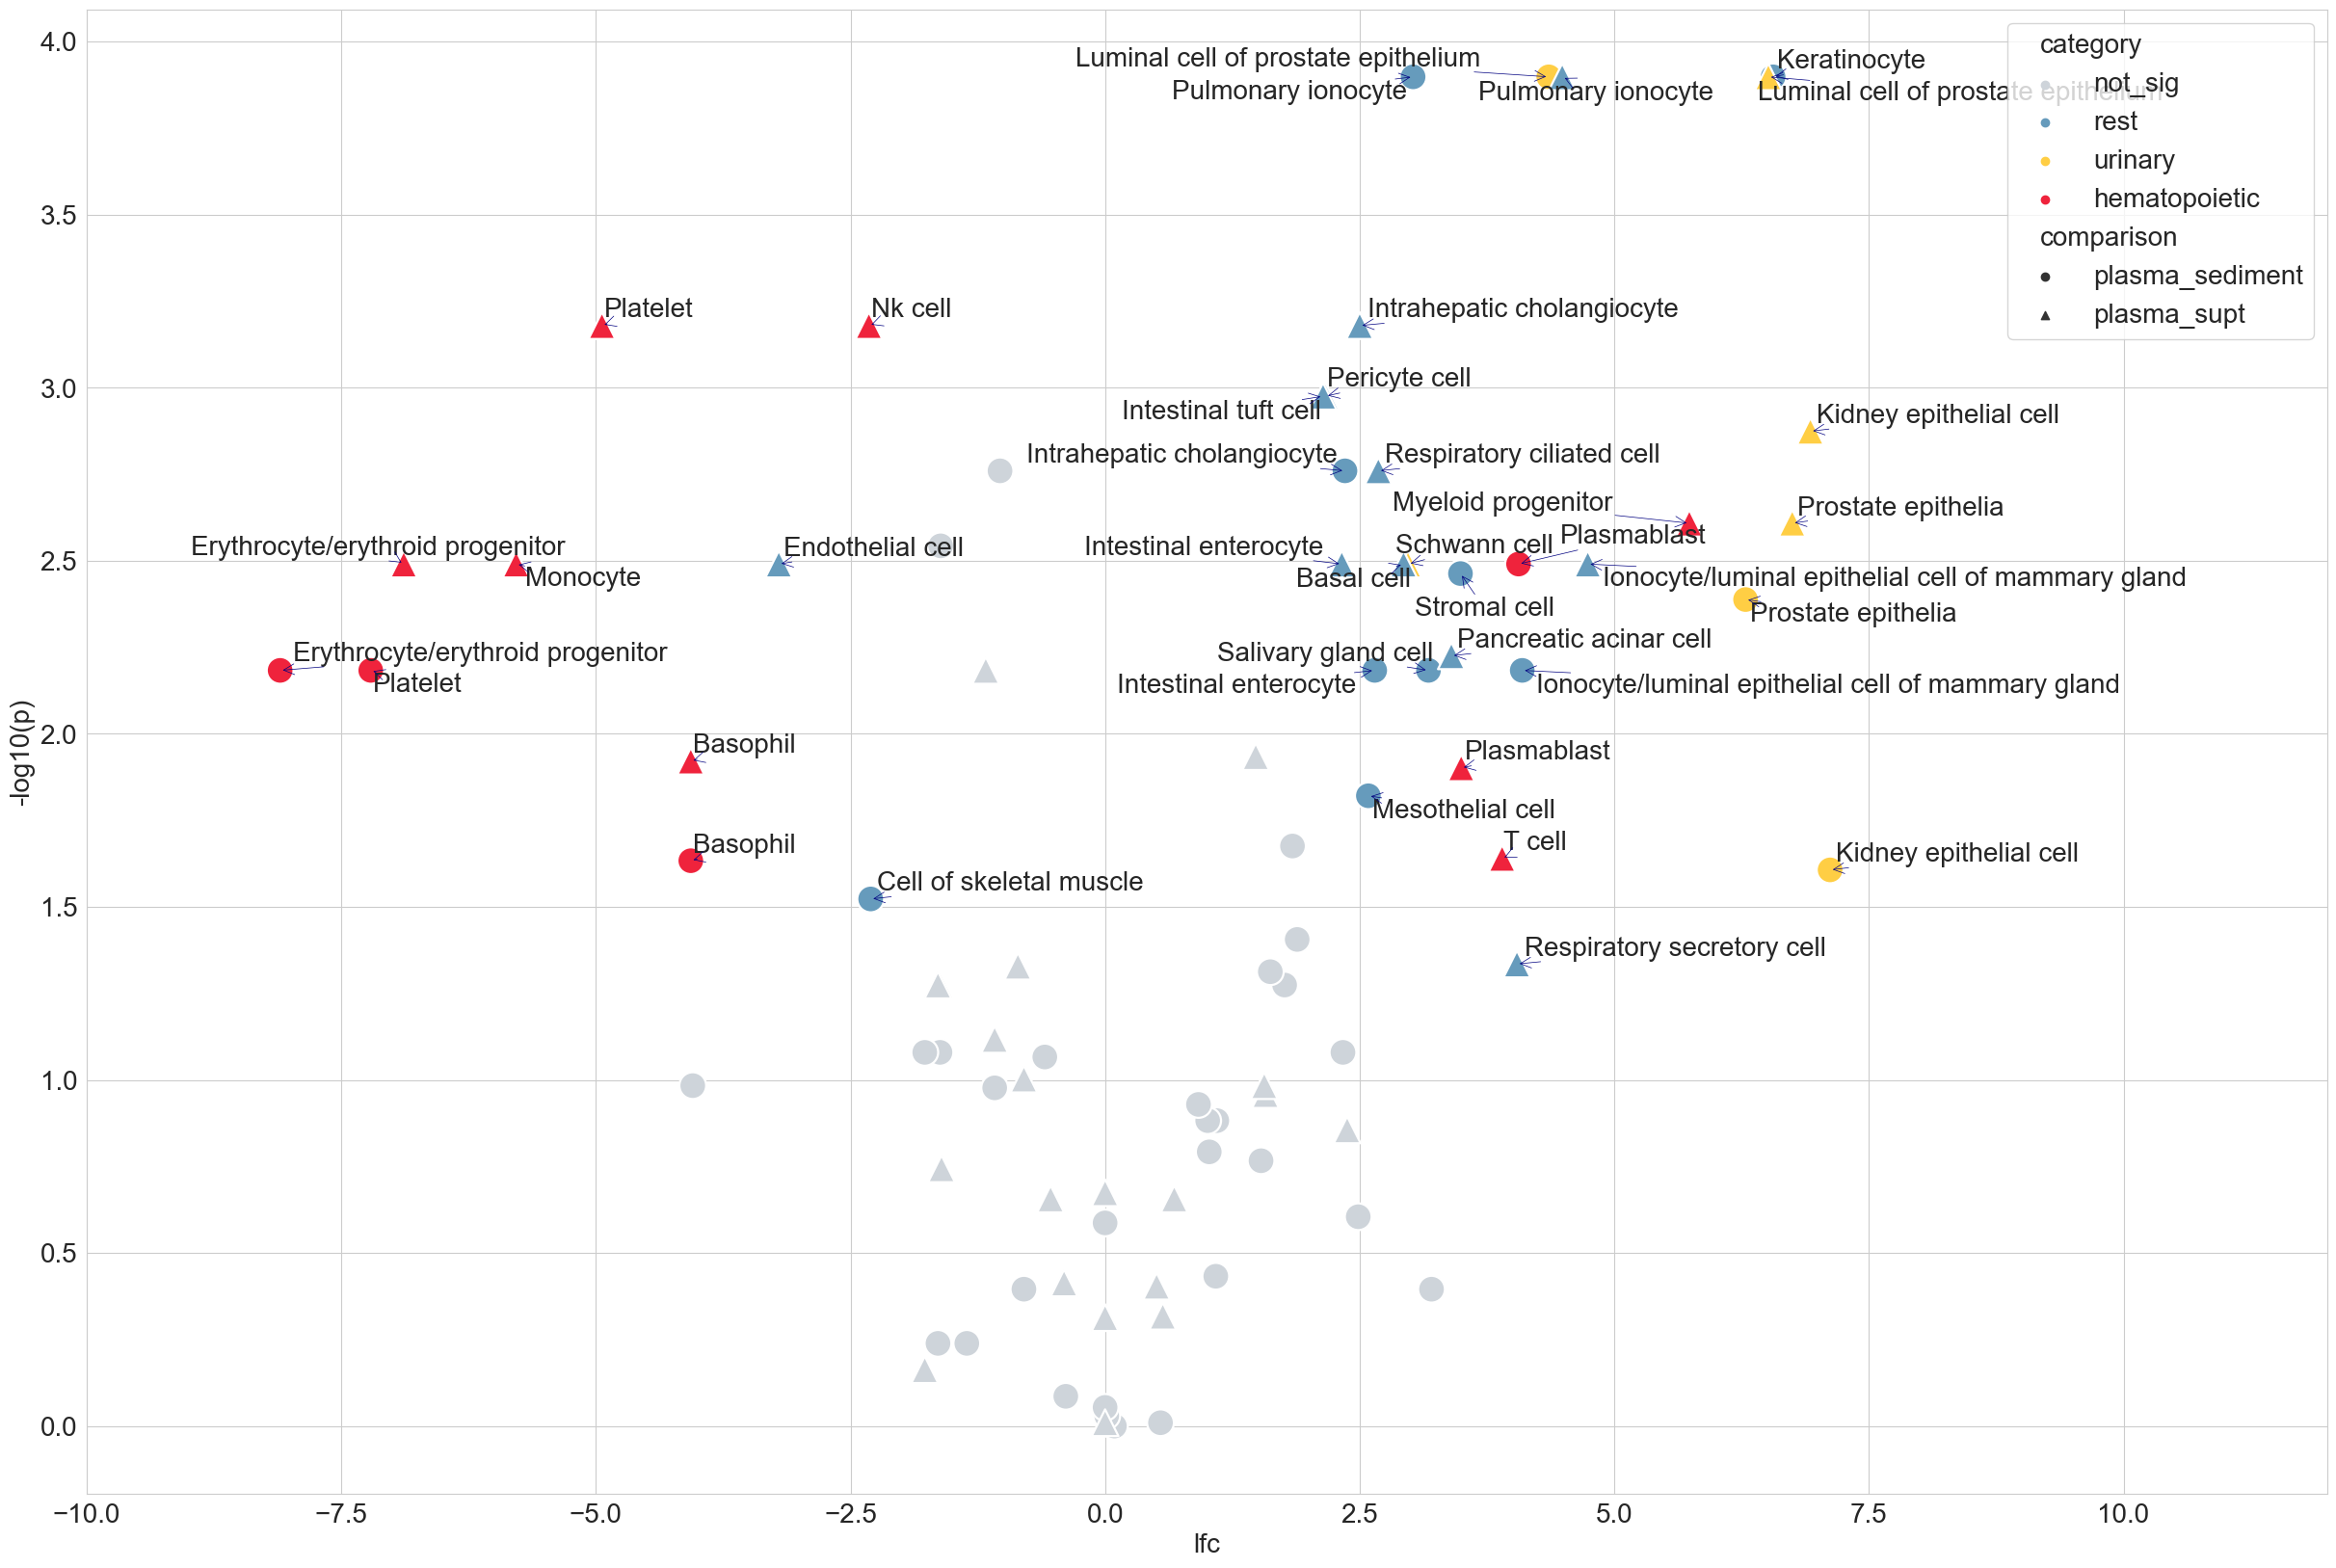

In [35]:
plt.figure(figsize = (30, 20))
sns.scatterplot(x = 'lfc',
               y = '-log10(p)',
               hue = 'category',
                style = 'comparison',
                markers = ['o', '^'],
                palette = color_pal,
                s = 400,
               data = res)
plt.xlim((-10, 12))
#plt.ylim((0, 3.5))
#plt.legend(bbox_to_anchor = (1, 1))

texts = []
x = []
y = []

for i, ct in enumerate(res.index):
    datapoint = res.iloc[i]
    if datapoint.category != 'not_sig':
        x += [datapoint.lfc]
        y += [datapoint['-log10(p)']]
        texts.append(plt.text(datapoint.lfc, datapoint['-log10(p)'], ct))

adjust_text(texts, x = x, y = y,
            #arrowprops=dict(arrowstyle='->', color='red'))
              arrowprops = dict(arrowstyle = "->",
                              color = 'navy',
                              lw = 0.5))

save_figure_pdf(plt, '../figures/manu_figs/volcano_biofluid_fullAnnotation.pdf')

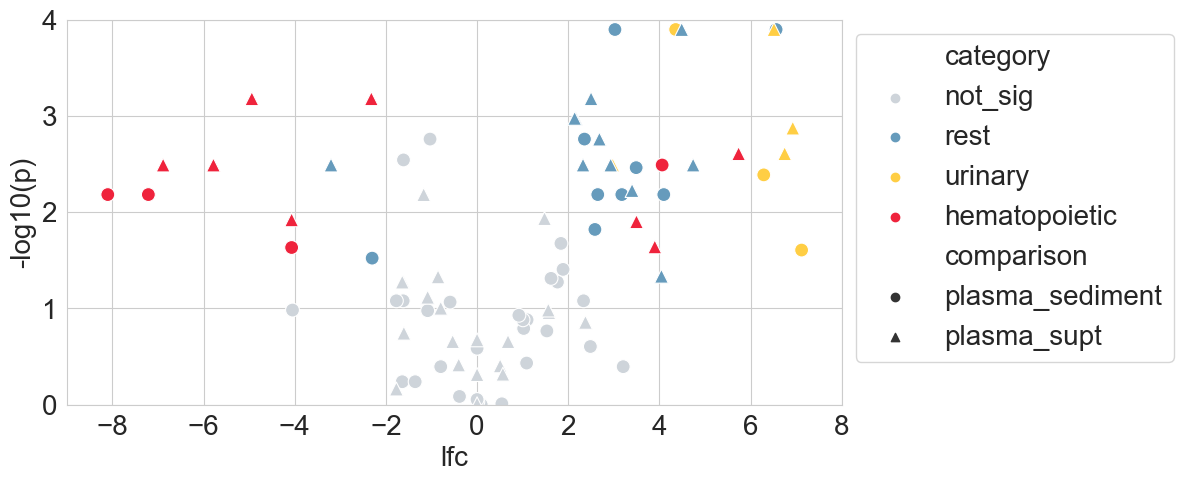

In [34]:
plt.figure(figsize = (10, 5))
sns.scatterplot(x = 'lfc',
               y = '-log10(p)',
                
               hue = 'category',
                style = 'comparison',
                markers = ['o', '^'],
                palette = color_pal, s = 100,
               data = res)
#plt.xlim((-9, 8))
plt.ylim((0, 4))
plt.xlim((-9, 8))
plt.legend(bbox_to_anchor = (1, 1))
save_figure_pdf(plt, '../figures/manu_figs/volcano_biofluid.pdf')